# IMPORTING THE LIB

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as mlt
import numpy as np

# Loading the data set

In [2]:
IMG_SIZE=256
BATCH_SIZE=28
CHANNELS=3

In [3]:
data1=tf.keras.preprocessing.image_dataset_from_directory(
    "Plant",
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 12803 files belonging to 9 classes.


# Data visualization

In [4]:
class_names = data1.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(class_names)

9

In [6]:
 for image_batch, label_batch in data1.take(1):
        print(image_batch.shape)
        print(image_batch[0].numpy())

(28, 256, 256, 3)
[[[160. 155. 152.]
  [155. 150. 147.]
  [153. 148. 145.]
  ...
  [148. 142. 144.]
  [147. 141. 143.]
  [138. 132. 134.]]

 [[162. 157. 154.]
  [157. 152. 149.]
  [155. 150. 147.]
  ...
  [156. 150. 152.]
  [157. 151. 153.]
  [149. 143. 145.]]

 [[164. 159. 156.]
  [158. 153. 150.]
  [153. 148. 145.]
  ...
  [156. 150. 152.]
  [159. 153. 155.]
  [151. 145. 147.]]

 ...

 [[ 98.  89.  92.]
  [ 92.  83.  86.]
  [ 91.  82.  85.]
  ...
  [112. 103. 106.]
  [115. 106. 109.]
  [120. 111. 114.]]

 [[102.  93.  96.]
  [ 99.  90.  93.]
  [ 99.  90.  93.]
  ...
  [112. 103. 106.]
  [114. 105. 108.]
  [116. 107. 110.]]

 [[106.  97. 100.]
  [104.  95.  98.]
  [106.  97. 100.]
  ...
  [113. 104. 107.]
  [113. 104. 107.]
  [111. 102. 105.]]]


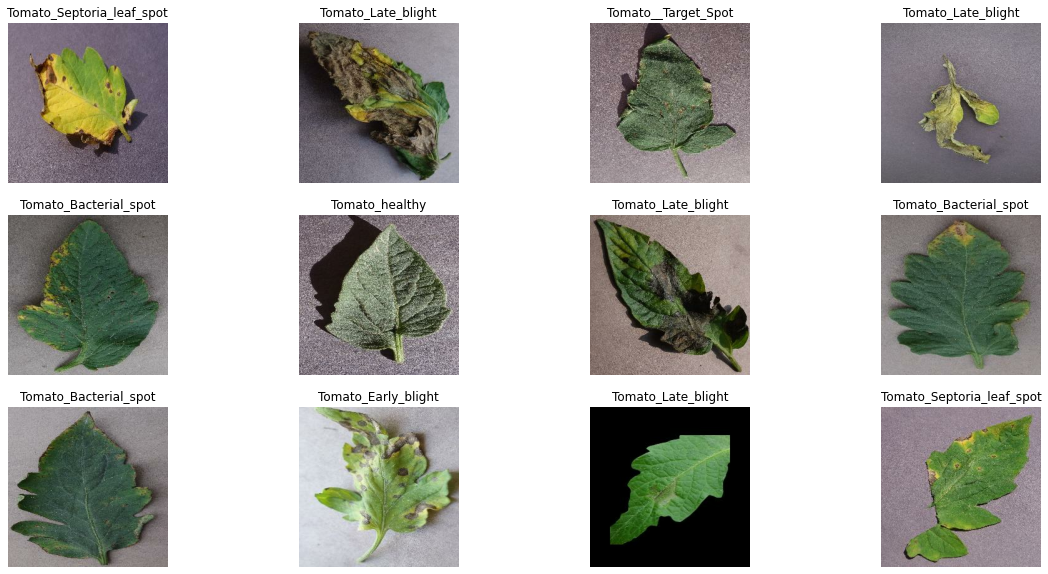

In [7]:
mlt.figure(figsize=(20,10))
for image_batch, label_batch in data1.take(1):
    for i in range(12):
        ax = mlt.subplot(3,4,i+1)
        mlt.imshow(image_batch[i].numpy().astype('uint8'))
        mlt.title(class_names[label_batch[i]])
        mlt.axis("off")


# Spliting the data

In [8]:
len(data1)

458

In [9]:
def get_dataset_div_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=5)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
    

In [10]:
train_ds,val_ds,test_ds=get_dataset_div_tf(data1)

In [11]:
len(train_ds)

366

In [12]:
len(val_ds)

45

In [13]:
len(test_ds)

47

## using gpu and cpu together

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data preprocessing

In [15]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),# to convert the supplied image acc. to the model 
    layers.experimental.preprocessing.Rescaling(1.0/255) # to cover the rgb
    
]) 

In [16]:
#for slight variation like rotation,zoom etc
data_augment=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

# Buliding the model

In [17]:
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
n_classes = len(class_names)


model = models.Sequential([
    resize_rescale,
    data_augment,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (28, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [21]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [22]:
history=model.fit(
    train_ds,
    epochs=35,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/35
272/366 [=====================>........] - ETA: 2:27 - loss: 0.2327 - accuracy: 0.9206

KeyboardInterrupt: 

In [25]:
scores=model.evaluate(test_ds)

47/47 [==============================] - 14s 293ms/step - loss: 0.6269 - accuracy: 0.8463


In [26]:
epochs=35

# Plotting the Accuracy and Loss Curves

In [27]:
history.params

{'verbose': 1, 'epochs': 35, 'steps': 366}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

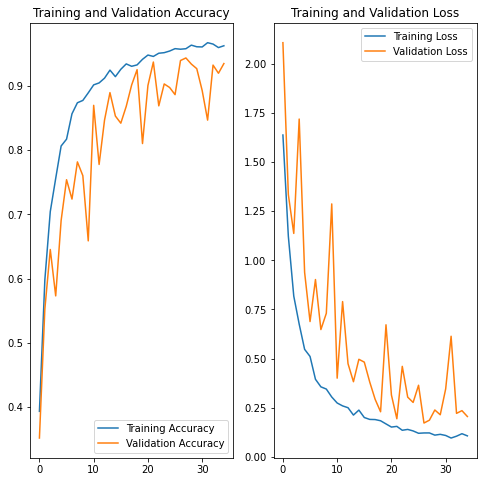

In [30]:
mlt.figure(figsize=(8, 8))
mlt.subplot(1, 2, 1)
mlt.plot(range(epochs), acc, label='Training Accuracy')
mlt.plot(range(epochs), val_acc, label='Validation Accuracy')
mlt.legend(loc='lower right')
mlt.title('Training and Validation Accuracy')

mlt.subplot(1, 2, 2)
mlt.plot(range(epochs), loss, label='Training Loss')
mlt.plot(range(epochs), val_loss, label='Validation Loss')
mlt.legend(loc='upper right')
mlt.title('Training and Validation Loss')
mlt.show()

# function

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


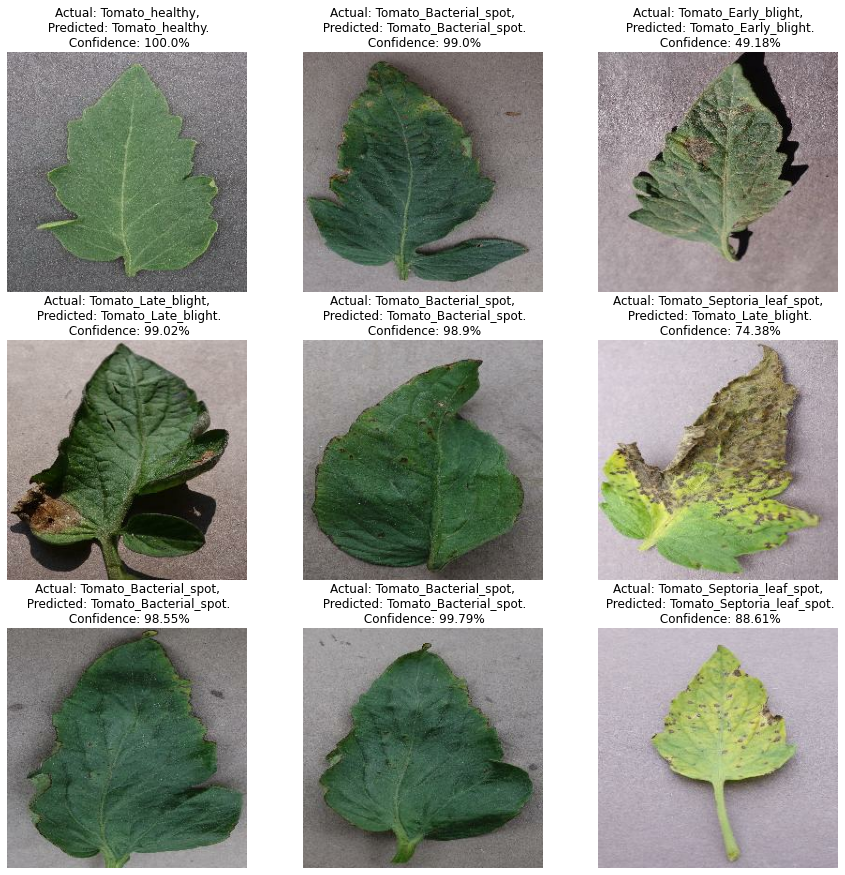

In [32]:
mlt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = mlt.subplot(3, 3, i + 1)
        mlt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        mlt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        mlt.axis("off")

In [33]:
print(class_names[2])

Tomato_Late_blight


In [34]:
data1.class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [35]:
model_No=3
model.save(f"../models/{model_No}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


In [31]:
model_No="sec"
model.save(f"../models/{model_No}")

INFO:tensorflow:Assets written to: ../models/sec\assets


INFO:tensorflow:Assets written to: ../models/sec\assets
